# BDPP Course lab 2 (Resilient Distributed Datasets)

<img src='files/lab2_header.png'></img>

Welcome to the second lab of BDPP course! 

Here is a summary of what we will cover in this lab:

- Work with the SparkContext and SparkSession objects
- Speed benchmarking (local and on the cloud)
- Work with Resilient Distributed Datasets
- Implementing PageRank Algorithm using spark

<a id="sparkcontext"></a>
## 2. Work with the SparkContext and SparkSession objects

The Spark driver application uses the SparkContext object to allow a programming interface to interact with the driver application. The SparkContext object tells Spark how and where to access a cluster. The Google Cloud predefines the Spark context for you. The object name to access the Spark session is `sc`.

In other environments, you need to pick an interpreter (for example, pyspark for Python) and create a SparkConf object to initialize a SparkContext object. For example:
<br>
`from pyspark import SparkContext, SparkConf`<br>
`conf = SparkConf().setAppName(appName).setMaster(master)`<br>
`sc = SparkContext(conf=conf)`<br>

<a id="sparkcontext1"></a>
### 2.1 Invoke the SparkContext
Run the following cell to invoke the SparkContext. 

__Note:__ If you ran this jupyter file using `pyspark` command or on the Google cloud, the SparkContext object might already exist in the memory. You can check this by running `sc`command in a notebook cell.

In [4]:
from pyspark import SparkContext, SparkConf
try:
    conf = SparkConf().setAppName('Spark Lab2')
    sc = SparkContext(conf=conf)
    sc.setLogLevel("ERROR")

except:
    pass
sc

22/04/03 13:26:56 WARN Utils: Your hostname, ahembal-ThinkPad resolves to a loopback address: 127.0.1.1; using 192.168.88.232 instead (on interface wlp0s20f3)
22/04/03 13:26:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/03 13:26:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local[*] appName=Spark Lab2>

__Remember__ that you can create only one instance of the `SparkContext` object (`sc`) in each pyspark session. This means that if you run the above code snippet again, you get the following error:

<font color='red'>ValueError</font>:`Cannot run multiple SparkContexts at once; existing SparkContext(app=My app, master=local) created by __init__ ... ` 

Moreover, you have to close your Spark session at the end of your program. This can be done by calling the `stop` function: `sc.stop()`. It ensures that you will not face any problem connecting to Spark again.

The same goes for the `SparkSession` object.

#### Check the Spark version
Check the version of the Spark driver application:

In [2]:
sc.version

'3.1.2'

### 2.2 SparkSession

Prior to Spark 2.0.0, `sparkContext` was used as a channel to access all spark functionality. From Spark 2.0.0 onwards, `SparkSession` provides a single point of entry to interact with underlying Spark functionality and allows programming Spark with DataFrame and Dataset APIs. The Google Cloud predefines the Spark session for you. The object name to access Spark session is `spark`.

In other environments, you need to pick an interpreter (for example, pyspark for Python) and create a Spark session object. For example:

In [6]:
from pyspark.sql import SparkSession

try:
    spark = SparkSession \
        .builder \
        .appName("Spark Lab2") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
except:
    pass

In [7]:
spark

All the functionality available with sparkContext are also available in sparkSession. If you need to access `SparkContext` through SparkSession use `sparkContext` attribute:

In [8]:
spark.sparkContext

<SparkContext master=local[*] appName=Spark Lab2>

### 2.3. Speed benchmark (Spark VS Pandas)

Now, let's use the `sparkSession` object to run a simple benchmark by comparing reading a relatively big CSV file with pandas VS Spark. Although we are still running Spark on our local computer, it ends up reading the file faster than pandas (note that the result highly depends on the parallelization capabilities of your CPU). This demonstrates how Spark dataframes are much faster when compared to their pandas equivalent.

For this experiment, we use a somewhat large Vermont vendor dataset. This data is accessible through [this link](https://data.vermont.gov/Finance/Vermont-Vendor-Payments/786x-sbp3). On this link, please select export and then choose CSV format. Download the file rename it to `Vermont_Vendor_Payments.csv` and place it in the `files` folder next to this notebook. Now, run the following two code snippets.

In [6]:
%%timeit

# loading csv file with Spark
housing = spark.read.csv("files/Vermont_Vendor_Payments.csv", header="true")

166 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# installl pandas library if you don't have it.

import pandas as pd

In [8]:
%%timeit

# loading csv file with Pandas
df_pandas = pd.read_csv("files/Vermont_Vendor_Payments.csv")

/home/ahembal/anaconda3/envs/testProject/lib/python3.9/site-packages/IPython/core/magics/execution.py:156: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  timing = self.inner(it, self.timer)


3.2 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div class="alert alert-block alert-info">

__Question1__: Use the cell below to report your observations from this experiment and compare the running times.
    
</div>

""" TODO: change the format of this cell to Markdown and answer the question here """
 Although we are still running Spark on our local computer, it ends up reading the file faster than pandas. This demonstrates how Spark dataframes are much faster when compared to their pandas equivalent. One thing to note is measured value does not represent real execution time because of caching feature of spark.

Spark:
The slowest run took 8.35 times longer than the fastest. This could mean that an intermediate result is being cached.
166 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Pandas:
3.2 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2.4. Speed benchmark (π calculation)

Spark can also be used for compute-intensive tasks. This code estimates π by "throwing darts" at a circle. We pick random points in the unit square ((0, 0) to (1,1)) and see how many fall in the unit circle. The fraction should be π / 4, so we use this to get our estimate.

In [9]:
# π calculation code

import random

num_samples = 10000000 # you can change this number, e.g. try 1000000

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

def spark_pi_calc():
    # here we do the pi calcaulation using Spark
    count = spark.sparkContext.parallelize(range(0, num_samples)).filter(inside).count()
    return (4.0 * count / num_samples)

def python_pi_calc():
    # here we do the same calculation with python list comprehension
    count = sum([inside(_) for throw in range(num_samples)])
    return (4.0 * count / num_samples)

In [10]:
# Depending on your hardware, this can take some time to fininsh.
# You can reduce num_samples if it is taking too much time.

print("[Spark] Pi is roughly:", spark_pi_calc())

[Spark] Pi is roughly: 3.1417276


In [11]:
# Depending on your hardware, this can take some time to fininsh.
# You can reduce num_samples if it is taking too much time.

print("[Python] Pi is roughly:", python_pi_calc())

[Python] Pi is roughly: 3.141656


Now, we use π calculation code to benchmark spark VS python. For small problems, python might work faster than spark because of the initial setup cost of spark. However, as the problem gets bigger, the spark code starts to show its benefit and runs faster than python.

In the code below, we start from a small `num_samples` and keep doubling it until the python loop exceeds `max_time` (here it is set to 3 seconds by default). We collect running times for spark and python codes and produce a plot displaying time VS num_samples. 

We want you to play with the `max_time` parameter until the problem gets big enough so that you observe the spark code runs faster than the python code. This, of course, highly depends on the parallelization capacity of your CPU, and you may end up getting different results.

In [12]:
import timeit, time

max_time = 10 # you can also try 1, 2, 5, and 10 depending on your hardware performance.

print('Running experiment. This may take a few minutes to run.')
print('You can change max_time value to increase or decrease run time.')
print('(please wait)')

num_samples = 10000
steps = []
python_times = []
sparks_times = []

def my_timeit(func):
    runs = 3  # If the experiment is still taking too much time to run, you may decrease this value as well.
    dtime = timeit.timeit(func, number=runs)
    elapsed = dtime/runs
    return elapsed

start = time.time()
while True:
    pt = my_timeit(python_pi_calc)
    st = my_timeit(spark_pi_calc)
    python_times.append(pt)
    sparks_times.append(st)
    steps.append(num_samples)
    print(min(int(pt * 100), max_time*100), '/', max_time*100)
    if pt > max_time:
        break
    elif pt < 0.1:
        num_samples = num_samples * 10
    else:
        num_samples = num_samples * 2
print(f"Done! Total time = {time.time()-start:.2f}s")

Running experiment. This may take a few minutes to run.
You can change max_time value to increase or decrease run time.
(please wait)
0 / 1000
2 / 1000
29 / 1000
59 / 1000


107 / 1000


201 / 1000


406 / 1000


815 / 1000


1000 / 1000
Done! Total time = 142.07s


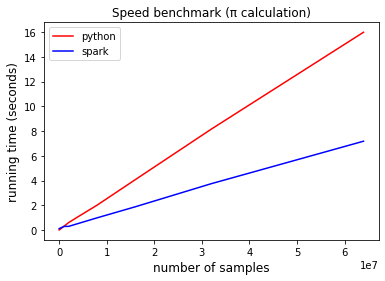

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(steps, python_times, color='red', label='python')
plt.plot(steps, sparks_times, color='blue', label='spark')
plt.legend()
plt.xlabel('number of samples', fontsize=12)
plt.ylabel('running time (seconds)', fontsize=12)
plt.title('Speed benchmark (π calculation)')
plt.show()

<div class="alert alert-block alert-info">

__Question2__: Use the cell below to report your observations from this experiment and compare the running times. Can Spark implementation run faster than Pandas on a single computer? How?

</div>

""" TODO: change the format of this cell to Markdown and answer the question here """
For small problems, python might work faster than spark because of the initial setup cost of spark.
However, depending on our cpu parallelization capabilities, as the problem gets bigger,
the spark code starts to show its benefit and runs faster than python as you can see on figure.
For example, looking at the figure we can say, for 3 samples, running time for spark is 3.5 sec but for python is almost 8 sec, 2 times longer than spark.


__Hint__: If you pick a big enough value for the `num_samples` parameter (code below), you should be able to see multiple python processes running at the same time in your (system monitor/task manager) when benchmarking spark code (A).

In [14]:
# code (A) Spark 
# Depending on your hardware, this can take some time to fininsh.
# You can reduce num_samples if it is taking too much time.

num_samples = 300000000  # reduce this number if it is taking too much time to run
spark_pi_calc()

3.1416451733333335

In [15]:
# code (B) Python - List Comprehension
# Depending on your hardware, this can take some time to fininsh.
# You can reduce num_samples if it is taking too much time.

num_samples = 100000000  # reduce this number if it is taking too much time to run
python_pi_calc()

3.141438

<br>
<br>
<img src="files/spark run.png">

<br>
<br>
This picture also demonstrates how Spark uses CPU VS python:
<br>
<br>

<img src="files/spark cpu load.png" width="300">

### 2.5. Speed benchmark on the Cloud (recommender system)

In this section, you are required to run a recommender system written using spark Mlib (cell below) with (at least) the following two configurations and compare their speed in a brief report:

1. Single Node (1 master (__2 vCPU__), __ZERO__ workers)
1. Standard (1 master (__1 vCPU__), __SEVEN__ workers (__1 vCPU each__))

__Change__ the machine type for both configurations to `Custom` and set the number of __vCPU__ core for master and worker nodes according to the specified configuration above.

__Note:__ Because of the resource limitations, you may not be able to create both cluster types together. If this issue happens, you can delete the previous cluster before making a new one.
Following are a few tips on how to create different types of clusters in GCP:

- This is how you can change the cluster type:
<img src="files/benchmark0.png">
- This is how you can change `number of workers` and `Machine Types`:
<img src="files/benchmark1.png">
- For the second experiment set `number of workers` to 7 in `standard cluster`:
<img src="files/benchmark2.png">

There are two files `u.data` and `u.item` located in the `files` folder. You should upload these files to your cloud storage and change the `your_bucket_name` variable according to your bucket name.

Here is the benchmark code you should run on the cloud:

In [ ]:
import time
import sys
from pyspark import SparkConf, SparkContext
from pyspark.mllib.recommendation import ALS, Rating

from google.cloud import storage

your_bucket_name = 'bdpp_bucket3'

client = storage.Client()
for blob in client.list_blobs(your_bucket_name):
    print(str(blob))

start = time.time()

def loadMovieNames():
    movieNames = {}
    item = sc.textFile("gs://" + your_bucket_name + "/u.item")
    for line in item.collect():
        fields = line.split('|')
        movieNames[int(fields[0])] = fields[1]

    return movieNames

conf = SparkConf().setMaster("local").setAppName("MovieRecommendationsALS")
try:
    sc = SparkContext(conf = conf)
except:
    pass
sc.setCheckpointDir('checkpoint')

print("\nLoading movie names...")
nameDict = loadMovieNames()


data = sc.textFile("gs://" + your_bucket_name + "/u.data")

ratings = data.map(lambda l: l.split()).map(lambda l: Rating(int(l[0]), \
                            int(l[1]), float(l[2])))#.cache()

ratings.collect()

data.collect()

start = time.time()
# Build the recommendation model using Alternating Least Squares
print("\nTraining recommendation model...")
rank = 10
# Lowered numIterations to ensure it works on lower-end systems
numIterations = 1000
model = ALS.train(ratings, rank, numIterations)
end = time.time()

print(end-start)

userID = 2

print("\nRatings for user ID " + str(userID) + ":")
userRatings = ratings.filter(lambda l: l[0] == userID)
for rating in userRatings.collect():
    print (nameDict[int(rating[1])] + ": " + str(rating[2]))

print("\nTop 10 recommendations:")
recommendations = model.recommendProducts(userID, 10)
for recommendation in recommendations:
    print (nameDict[int(recommendation[1])] + \
        " score " + str(recommendation[2]))

print(f"Done! Total time = {time.time()-start:.2f}s")

<div class="alert alert-block alert-info">

__Question3__: Run the above experiment three times for each configuration and report the running times and mean and standard deviation for each setup. Discuss how adding extra resources affects the running time?

</div>

""" TODO: change the format of this cell to Markdown and answer the question here """

-----Single Node (1 master (2 vCPU), ZERO workers)
Num of iterations(100): Total time = 23.36s
Num of iterations(150): Total time = 18.01s

---notebook restarted this point
Num of iterations(1000): Total time = 207.61s
Num of iterations(1500): Total time = 23.36s

Running times is as seen above, the first time on single node is quite long.
The large decreasing on running time after first run shows that an intermediate result is being cached.


-----Standard (1 master (1 vCPU), SEVEN workers (1 vCPU each))
Num of iterations(150): Total time = 56.25s
Num of iterations(150): Total time = 39.20s -running second time

According to measurements, 1 master (1 vCPU) machine with seven workers works slowly than single node machine(1 master (2 vCPU).
I think our resources are insufficient to run spark core properly. Because of that parallelization doesn't work at all.


<a id="rdd"></a>
## 3. Work with Resilient Distributed Datasets
Spark uses an abstraction for working with data called a Resilient Distributed Dataset (RDD). An RDD is a collection of elements that can be operated on in parallel. RDDs are immutable, so you can't update the data in them. To update data in an RDD, you must create a new RDD. In Spark, all work is done by creating new RDDs, transforming existing RDDs, or using RDDs to compute results. When working with RDDs, the Spark driver application automatically distributes the work across the cluster.

You can construct RDDs by parallelizing existing Python collections (lists), by manipulating RDDs, or by manipulating files in HDFS or any other storage system.

You can run these types of methods on RDDs:
 - Actions: query the data and return values
 - Transformations: manipulate data values and return pointers to new RDDs.

Find more information on Python methods in the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html" target="_blank" rel="noopener noreferrer">PySpark documentation</a>.

<a id="rdd1"></a>
### 3.1 Create a collection
Create a Python collection of the numbers 1 - 10:

In [16]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

<a id="rdd2"></a>
### 3.2 Create an RDD
Put the collection into an RDD named `x_nbr_rdd` using the `parallelize` method:

In [17]:
x_nbr_rdd = spark.sparkContext.parallelize(x)

Notice that there's no return value. The `parallelize` method didn't compute a result, which means it's a transformation. Spark just recorded how to create the RDD.

<a id="rdd3"></a>
### 3.3 View the data 
View the first element in the RDD:

In [18]:
x_nbr_rdd.first()

1

Each number in the collection is in a different element in the RDD. Because the `first()` method returned a value, it is an action. 

Now view the first five elements in the RDD:

In [19]:
x_nbr_rdd.take(5)

[1, 2, 3, 4, 5]

<a id="rdd4"></a>
### 3.4 Create another RDD 
Create a Python collection that contains strings:

In [2]:
y = ["Hello Human", "My Name is Spark"]

Put the collection into an RDD:

In [9]:
y_str_rdd = spark.sparkContext.parallelize(y)

View the first element in the RDD:

In [10]:
y_str_rdd.take(1)

['Hello Human']

In [21]:
y_new = y_str_rdd.flatMap(lambda y: y.split(' '))

In [22]:
y_new.collect()

['Hello', 'Human', 'My', 'Name', 'is', 'Spark']

You created the string "Hello Human" and you returned it as the first element of the RDD. To analyze a set of words, you can map each word into an RDD element.

<a id="trans"></a>
## 4. Manipulate data in RDDs

Remember that to manipulate data, you use transformation functions.

Here are some common Python transformation functions that you'll be using in this notebook:

 - `map(func)`: returns a new RDD with the results of running the specified function on each element  
 - `filter(func)`: returns a new RDD with the elements for which the specified function returns true   
 - `distinct([numTasks]))`: returns a new RDD that contains the distinct elements of the source RDD
 - `flatMap(func)`: returns a new RDD by first running the specified function on all elements, returning 0 or more results for each original element, and then flattening the results into individual elements

You can also create functions that run a single expression and don't have a name with the Python `lambda` keyword. For example, this function returns the sum of its arguments: `lambda a , b : a + b`.

<a id="trans1"></a>
### 4.1 Update numeric values
Run the `map()` function with the `lambda` keyword to replace each element, X, in your first RDD (the one that has numeric values) with X+1. Because RDDs are immutable, you need to specify a new RDD name.

Now look at the elements of the new RDD:

In [24]:
x_nbr_rdd_2.collect()

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Be careful with the `collect` method! It returns __all__ elements of the RDD to the driver. Returning a large data set might be not be very useful. No-one wants to scroll through a million rows!

<a id="trans2"></a>
### 4.2 Add numbers in an array
An array of values is a common data format where multiple values are contained in one element. You can manipulate the individual values if you split them up into separate elements.

Create an array of numbers by including quotation marks around the whole set of numbers. If you omit the quotation marks, you get a collection of numbers instead of an array.

In [25]:
X = ["1,2,3,4,5,6,7,8,9,10"]

Create an RDD for the array:

In [26]:
y_rd = spark.sparkContext.parallelize(X)

Split the values at commas and add values in the positions 3 and 7 in the array. Keep in mind that an array starts with position 0. Use a backslash character, \, to break the line of code for clarity.

In [63]:
lst = y_rd.map(lambda y: y.split(',')).collect()

In [88]:
# TODO: Replace <FILL IN> with appropriate code

Sum_rd = y_rd.map(lambda y: y.split(',')).map(lambda y: int(y[3])+int(y[7]))
Sum_rd.collect()

[12]

Now return the value of the sum:

In [89]:
Sum_rd.first()

12

You should get `12`.

<a id="trans3"></a>
### 4.3 Split and count text strings

Create an RDD with a text string and show the first element:

In [36]:
Words = ["Hello Human. I'm Spark and I love running analysis on data."]
words_rd = spark.sparkContext.parallelize(Words)
words_rd.first()

"Hello Human. I'm Spark and I love running analysis on data."

Split the string into separate lines at the space characters and look at the first element:

In [38]:
# TODO: Replace <FILL IN> with appropriate code

Words_rd2 = words_rd.map(lambda line: line.split(' '))
Words_rd2.first()

['Hello',
 'Human.',
 "I'm",
 'Spark',
 'and',
 'I',
 'love',
 'running',
 'analysis',
 'on',
 'data.']

Count the number of elements in this RDD with the `count()` method:

In [39]:
Words_rd2.count()

1

You should get `1`.

Of course, you already knew that there was only one element because you ran the `first()` method and it returned the whole string. Splitting the string into multiple lines did not create multiple elements.

Now split the string again, but this time with the `flatmap()` method, and look at the first three elements:

In [40]:
# TODO: Replace <FILL IN> with appropriate code

words_rd2 = words_rd.flatMap(lambda line: line.split(' '))
words_rd2.take(3)

['Hello', 'Human.', "I'm"]

In [41]:
words_rd2.count()

11

You should get `11`.
This time each word is separated into its own element.

<a id="trans4"></a>
### 4.4 Count words with a pair RDD
A common way to count the number of instances of words in an RDD is to create a pair RDD. A pair RDD converts each word into a key-value pair: the word is the key and the number 1 is the value. Because the values are all 1, when you add the  values for a particular word, you get the number of instances of that word.

Create an RDD:

In [42]:
z = ["First,Line", "Second,Line", "and,Third,Line"]
z_str_rdd = spark.sparkContext.parallelize(z)
z_str_rdd.first()

'First,Line'

In [23]:
# TODO: Replace <FILL IN> with appropriate code

x_nbr_rdd_2 = x_nbr_rdd.map(lambda x: x+1)

Split the elements into individual words with the `flatmap()` method:

In [43]:
z_str_rdd_split_flatmap = z_str_rdd.flatMap(lambda line: line.split(","))
z_str_rdd_split_flatmap.collect()

['First', 'Line', 'Second', 'Line', 'and', 'Third', 'Line']

Convert the elements into key-value pairs:

In [47]:
countWords = z_str_rdd_split_flatmap.map(lambda word: (word,1))
countWords.collect()

[('First', 1),
 ('Line', 1),
 ('Second', 1),
 ('Line', 1),
 ('and', 1),
 ('Third', 1),
 ('Line', 1)]

Now sum all the values by key to find the number of instances for each word: 

In [45]:
from operator import add
countWords2 = countWords.reduceByKey(add)
countWords2.collect()

[('Line', 3), ('Second', 1), ('First', 1), ('and', 1), ('Third', 1)]

Notice that the word `Line` has a count of 3.

<a id="filter"></a>
## 5. Filter data

The filter command creates a new RDD from another RDD based on a filter criteria.
The filter syntax is: 

`.filter(lambda line: "Filter Criteria Value" in line)`

Hint: Use a simple python `print` command to add a string to your Spark results and to run multiple actions in single cell.

Find the number of instances of the word `Line` in the `z_str_rdd_split_flatmap` RDD:

In [48]:
# TODO: Replace <FILL IN> with appropriate code

words_rd3 = z_str_rdd_split_flatmap.filter(lambda line: 'Line' in line)

print ("The count of words " + str(words_rd3.first()))
print ("Is: " + str(words_rd3.count()))

The count of words Line
Is: 3


You should get `3`.

<a id="wordfile"></a>
## 6. Analyze text data from a file
In this section, you'll use a text file `README.txt` to create an RDD from it, and analyze the text in it. The file should already exist on `files`folder next to this notebook.

<a id="wordfile2"></a>
### 6.2 Create an RDD from the file
Use the `textFile` method to create an RDD named `textfile_rdd` based on the `README.txt` file. The RDD will contain one element for each line in the `README.txt` file.
Also, count the number of lines in the RDD, which is the same as the number of lines in the text file. 

In [25]:
textfile_rdd = spark.sparkContext.textFile("files/README.txt")
textfile_rdd.count()

98

<a id="wordfile3"></a>
### 6.3 Filter for a word 
Filter the RDD to keep only the elements that contain the word "Spark" with the `filter` transformation:

In [26]:
# TODO: Replace <FILL IN> with appropriate code

Spark_lines = textfile_rdd.filter(lambda line: 'Spark' in line)
Spark_lines.first()

'# Apache Spark'

You should see `'# Apache Spark'`

Count the number of elements in this filtered RDD and present the result as a concatenated string:

In [27]:
# TODO: Replace <FILL IN> with appropriate code

print ("The file README.txt has " + str(Spark_lines.count()) + \
" of " + str(textfile_rdd.count()) + \
" Lines with word Spark in it.")

The file README.txt has 19 of 98 Lines with word Spark in it.


You should see `The file README.txt has 19 of 98 Lines with word Spark in it.`

<a id="wordfile4"></a>
### 6.4 Count the instances of a string at the beginning of words
Count the number of times the substring "Spark" appears at the beginning of a word in the original text.

Here's what you need to do: 

1. Run a `flatMap` transformation on the Spark_lines RDD and split on white spaces.
2. Create an RDD with key-value pairs where the first element of the tuple is the word and the second element is the number 1.
3. Run a `reduceByKey` method with the `add` function to count the number of instances of each word.<br>
4. Filter the resulting RDD to keep only the elements that start with the word "Spark". In Python, the syntax to determine whether a string starts with a token is: `string.startswith("token")` 
5. Display the resulting list of elements that start with "Spark".

In [36]:
# TODO: write your code here.
Spark_lines_s = Spark_lines.flatMap(lambda l: l.split(' '))
Spark_lines_sd = Spark_lines_s.map(lambda l: (l,1))
Spark_lines_sdr = Spark_lines_sd.reduceByKey(lambda a,b : a+b)
Spark_lines_sdrs = Spark_lines_sdr.filter(lambda line: line[0].startswith('Spark'))
Spark_lines_sdrs.collect()

[('Spark', 14),
 ('Spark"](http://spark.apache.org/docs/latest/building-spark.html).', 1),
 ('SparkPi', 2),
 ('Spark](#building-spark).', 1),
 ('Spark.', 1)]

You should see:<br>
<pre>
[('Spark', 14),
 ('Spark"](http://spark.apache.org/docs/latest/building-spark.html).', 1),
 ('SparkPi', 2),
 ('Spark](#building-spark).', 1),
 ('Spark.', 1)]
</pre>

<a id="wordfile5"></a>
### 6.5 Count instances of a string within words
Now filter and display the elements that contain the substring "Spark" anywhere in the word, instead of just at the beginning of words like the last section. Your result should be a superset of the previous result.

The Python syntax to determine whether a string contains a particular token is: `"token" in string`

In [37]:
# TODO: write your code here.
Spark_lines_sdrss = Spark_lines_sdr.filter(lambda line: 'Spark' in line[0])
Spark_lines_sdrss.collect()

[('Spark', 14),
 ('Spark"](http://spark.apache.org/docs/latest/building-spark.html).', 1),
 ('SparkPi', 2),
 ('Spark](#building-spark).', 1),
 ('Spark.', 1),
 ('tests](https://cwiki.apache.org/confluence/display/SPARK/Contributing+to+Spark#ContributingtoSpark-AutomatedTesting).',
  1)]

You should see:
<pre>
[('Spark', 14),
 ('Spark"](http://spark.apache.org/docs/latest/building-spark.html).', 1),
 ('SparkPi', 2),
 ('Spark](#building-spark).', 1),
 ('Spark.', 1),
 ('tests](https://cwiki.apache.org/confluence/display/SPARK/Contributing+to+Spark#ContributingtoSpark-AutomatedTesting).',
  1)]
</pre>

<a id="numfile"></a>
## 7. Analyze numeric data from a file
You'll analyze a sample file `Scores.txt` given in `files` folder that contains instructor names and scores. The file has the following format: Instructor Name,Score1,Score2,Score3,Score4,... The number of scores for each instructor could be diferent.
Here is an example line from the text file: "Carlo,5.5,3,3,4" or "Pablo,9,10,8.6,7,9,5,6"
Your task is to look at all the scores from each instructor and find the maximum score given by each instructor:

1. Load the text file into an RDD.
1. Run a transformation to create an RDD with the instructor names and the scores per instructor.
1. Run a second transformation to compute the maximum score for each instructor.
1. Display the results.

In [87]:
# TODO: write your code here.
data = spark.sparkContext.textFile("files/Scores.txt")
datac = data.map(lambda y: y.split(',',1))
datad = datac.map(lambda y: (y[0], [float(i) for i in y[1].split(',')] ))
dataf = datad.map(lambda y: (y[0], max(y[1])))
dataf.collect()

[('Tobias', 8.0),
 ('Malin', 10.0),
 ('Ali', 8.7),
 ('Magnus', 5.0),
 ('Alice', 9.1),
 ('Jack', 7.4)]

You should see:
<pre>
[('Tobias', 8.0),
 ('Malin', 10.0),
 ('Ali', 8.7),
 ('Magnus', 5.0),
 ('Alice', 9.1),
 ('Jack', 7.4)]
</pre>

## 8. PageRank Algorithm

In the final task, we are interested in using Spark to rank a list of websites based on their importance. One obvious application of such an analysis is to provide the ordering for web searches. To measure the importance of a page, you are tasked to calculate `PageRank`. PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites. The PageRank algorithm is very well described in Chapter 5 of the book `Mining Massive Data Sets`. You can access the book through [this link](http://www.mmds.org/).

The websites are stored in a file named `urls.txt` located in the `files` folder. The input file has the following format:

<pre>
URL, neighbor URL
URL, neighbor URL
URL, neighbor URL
...
</pre>


In the output, sort the websites descending based on their level of importance.

In [179]:
def computeContribs(urls, rank):
    """Calculates URL contributions to the rank of other URLs."""
    num_urls = len(urls)
    for url in urls:
        yield (url, rank / num_urls)

In [191]:
lines = spark.sparkContext.textFile('files/urls_link.txt')
links = lines.map(lambda urls: (urls.split(', ')[0], urls.split(', ')[1])).distinct().groupByKey().map(lambda line: (line[0], list(line[1]))).cache()
links.collect()

[('halmstad.se',
  ['google.com',
   'wikipedia.org',
   'twitter.com',
   'yelp.com',
   'apple.com',
   'hh.se',
   'imdb.com',
   'blocket.se',
   'halmstad.se',
   'instagram.com',
   'youtube.com',
   'wiktionary.org',
   'amazon.com']),
 ('imdb.com',
  ['wikipedia.org',
   'twitter.com',
   'google.com',
   'instagram.com',
   'urbandictionary.com',
   'apple.com',
   'youtube.com',
   'facebook.com',
   'wiktionary.org']),
 ('apple.com',
  ['merriam-webster.com',
   'visithalland.com',
   'google.com',
   'wikipedia.org',
   'twitter.com',
   'imdb.com',
   'amazon.com',
   'facebook.com',
   'youtube.com']),
 ('merriam-webster.com',
  ['wikipedia.org',
   'blocket.se',
   'tripadvisor.com',
   'apple.com',
   'twitter.com',
   'google.com',
   'imdb.com',
   'youtube.com',
   'amazon.com',
   'facebook.com',
   'fandom.com']),
 ('wikipedia.org',
  ['wikipedia.org',
   'hh.se',
   'twitter.com',
   'google.com',
   'merriam-webster.com',
   'tripadvisor.com',
   'youtube.com',
 

In [192]:
ranks = links.map(lambda url_neighbors: (url_neighbors[0], 1.0))
ranks.collect()

[('halmstad.se', 1.0),
 ('imdb.com', 1.0),
 ('apple.com', 1.0),
 ('merriam-webster.com', 1.0),
 ('wikipedia.org', 1.0),
 ('instagram.com', 1.0),
 ('blocket.se', 1.0),
 ('tripadvisor.com', 1.0),
 ('twitter.com', 1.0),
 ('google.com', 1.0),
 ('hh.se', 1.0),
 ('urbandictionary.com', 1.0),
 ('visithalland.com', 1.0),
 ('yelp.com', 1.0),
 ('wiktionary.org', 1.0),
 ('youtube.com', 1.0),
 ('facebook.com', 1.0),
 ('fandom.com', 1.0),
 ('amazon.com', 1.0)]

In [193]:
from operator import add
for iteration in range(5):
        # Calculates URL contributions to the rank of other URLs.
        contribs = links.join(ranks).flatMap(lambda url_urls_rank: computeContribs(url_urls_rank[1][0], url_urls_rank[1][1]))

        # Re-calculates URL ranks based on neighbor contributions.
        links_ranks = contribs.reduceByKey(add).mapValues(lambda rank: rank * 0.85 + 0.15)



In [194]:
links_ranks_sorted = links_ranks.sortBy(lambda x: -x[1])
for (link, rank) in links_ranks_sorted.collect():
        print("%s PageRank: %s." % (link, rank))

google.com PageRank: 1.7734207459207458.
wikipedia.org PageRank: 1.7734207459207458.
youtube.com PageRank: 1.6671707459207457.
facebook.com PageRank: 1.630763403263403.
twitter.com PageRank: 1.582170745920746.
amazon.com PageRank: 1.372031857031857.
imdb.com PageRank: 1.2610596348096346.
merriam-webster.com PageRank: 1.18760101010101.
apple.com PageRank: 1.0343929681429682.
fandom.com PageRank: 0.9477583527583529.
tripadvisor.com PageRank: 0.8114578477078477.
wiktionary.org PageRank: 0.7948475135975136.
yelp.com PageRank: 0.6201252913752913.
urbandictionary.com PageRank: 0.6151388888888889.
instagram.com PageRank: 0.5546581196581196.
blocket.se PageRank: 0.4579351204351204.
hh.se PageRank: 0.3853846153846154.
halmstad.se PageRank: 0.2862179487179487.
visithalland.com PageRank: 0.24444444444444444.


The `PageRank` algorithm has some variants. Based on how you implement the algorithm and the parameters you choose, you will end up geting different scores and ranks. Following is one example output. Make sure your produced ranking makes sense, e.g. `google.com` should recieve higher score compared to `merriam-webster.com`.

<pre>
1) google.com PageRank:1.8086487117025336
2) wikipedia.org PageRank:1.8086487117025336
3) facebook.com PageRank:1.777648228912891
4) youtube.com PageRank:1.7021245199883723
5) twitter.com PageRank:1.5510244219266531
6) amazon.com PageRank:1.3904212544003804
7) imdb.com PageRank:1.3008511398069642
8) merriam-webster.com PageRank:1.1146111418335307
9) fandom.com PageRank:1.002580594391505
10) tripadvisor.com PageRank:0.9650177901770668
11) apple.com PageRank:0.889833856208652
12) urbandictionary.com PageRank:0.783325788483356
13) wiktionary.org PageRank:0.7344188304535614
14) instagram.com PageRank:0.488708566583417
15) blocket.se PageRank:0.4475515972949302
16) yelp.com PageRank:0.40433532158209406
17) hh.se PageRank:0.3986772304305001
18) visithalland.com PageRank:0.2340398586683635
19) halmstad.se PageRank:0.19753243545269022
</pre>

<div class="alert alert-block alert-danger">

__IMPORTANT__ 

Please complete this Jupyter Notebook file. Then __rename the file using following format__:  "`BDPP_2022_Lab2_NameSurname_NameSurname.ipynb`" and submit it to the BalckBoard __within the specified deadline in blackboard__. 

</div>